In [3]:
# %load gen_response_data.py
#!/usr/bin/env python
# ==================================
# File Name: gen_response_data.py
# Author: En-Kun Li, Han Wang
# Mail: lienk@mail.sysu.edu.cn, wanghan657@mail2.sysu.edu.cn
# Created Time: 2023-08-31 09:40:34
# ==================================

import time
import numpy as np
import matplotlib.pyplot as plt

from gwspace.Waveform import waveforms
from gwspace.response import get_y_slr_td, trans_y_slr_fd, get_XYZ_td, get_XYZ_fd, get_AET_fd, tdi_XYZ2AET
from gwspace.Orbit import detectors
from gwspace.Constants import DAY, YRSID_SI, J0806_phi, J0806_theta

In [4]:
from gwspace.Constants import G_SI, MSUN_SI, C_SI, MPC_SI

G_SI*MSUN_SI/C_SI**3

4.925492321898863e-06

In [16]:
def generate_td_data(pars, Tobs=YRSID_SI, dt=1, s_type='gcb', det='TQ', show_y_slr=False):
    print("This is TD response generation code")

    # tf = np.arange(0,Tobs, dt)
    # be careful, the arange method will lose the largest value
    tf = np.linspace(0, Tobs, int(Tobs/dt))

    print(f"Testing of {s_type} waveform")
    wf = waveforms[s_type](**pars)
    st = time.time()
    y_slr = get_y_slr_td(wf, tf, det)
    ed = time.time()
    print(f"Time cost is {ed-st} s for {tf.shape[0]} points")

    if show_y_slr:
        tags = [(1, 2), (2, 1), (2, 3), (3, 2), (3, 1), (1, 3)]
        for i, tag in enumerate(tags):
            plt.figure()
            for j in range(4):
                plt.subplot(4, 1, j+1)
                plt.plot(tf, y_slr[tag][f"{j}L"])
                plt.title(f"y_{tag} [{j}]L")

    st = time.time()
    X, Y, Z = get_XYZ_td(y_slr)
    A, E, T = tdi_XYZ2AET(X, Y, Z)
    ed = time.time()
    print("Time cost for cal XYZ and AET with y_slr is ", ed-st)
    # np.save(det+s_type+"_X_td.npy", np.array([tf, X]))

    return tf,X,Y,Z,A,E,T



In [17]:
f0 = [0.00622028]
fd = [7.48528554e-16]
beta = [-0.082205]  # ecliptic latitude [rad]
Lambda = [2.10225]  # ecliptic longitude [rad]

Amp = [6.37823e-23]
iota = [0.645772]
psi = [2.91617795]
phi0 = [3.1716561]
Tobs = 62914560.0
Cadence = 15.0

In [18]:
GCBpars = {
    "mass1": 0.5,
    "mass2": 0.275,
    "DL": 0.004716164547019551,
    "phi0": 3.1716561,
    "f0": 0.00622028,
    "fdot": 7.48528554e-16,
    "fddot": 0.0,
    "psi": 0.2,
    "iota": 0.645772,
    "Lambda": J0806_phi, #2.10225,
    "Beta": J0806_theta, #np.pi/2+0.082205,
    "T_obs": YRSID_SI,
}

In [19]:
gcbwf = waveforms["gcb"](**GCBpars, dt=15)

In [20]:
gcbwf.amp/Amp[0]

1.0003126811351408

In [21]:
tf,X,Y,Z,A,E,T = generate_td_data(GCBpars, dt=15)

This is TD response generation code
Testing of gcb waveform
Time cost is 4.22951865196228 s for 2103876 points
Time cost for cal XYZ and AET with y_slr is  0.07269978523254395


In [22]:
dt = 15
fs = 1/dt

X_fd = np.fft.rfft(X)/len(X)*2

xf = np.linspace(0,fs/2,len(X_fd))

/tmp/ipykernel_242071/2465942627.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(xf, np.abs(1j*X_fd/np.pi/xf))
/tmp/ipykernel_242071/2465942627.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(xf, np.abs(1j*X_fd/np.pi/xf))


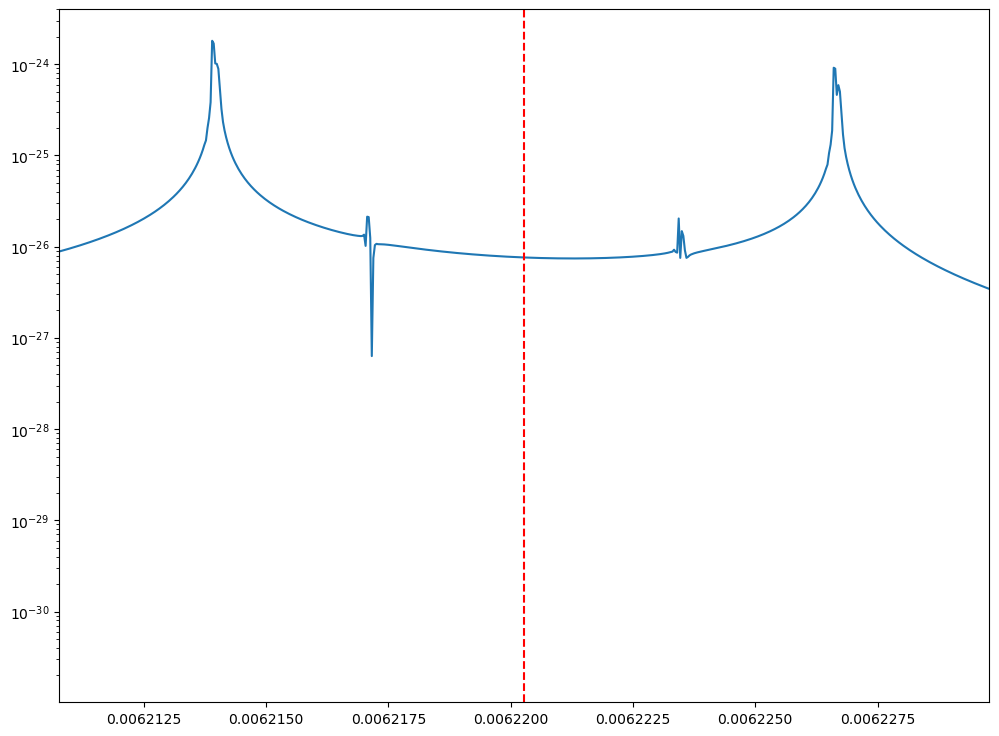

In [23]:
plt.figure(figsize=(12,9))
#plt.plot(tf,X)
plt.plot(xf, np.abs(1j*X_fd/np.pi/xf))

f0 = GCBpars["f0"]

plt.axvline(f0, color="red", ls="--")

df = xf[1]-xf[0]
plt.xlim(f0-300*df, f0+300*df)
#plt.xlim(0.025,0.030)
#plt.xscale("log")
plt.yscale("log")

In [40]:
from gwspace.Constants import EarthOrbitFreq_SI

In [41]:
EarthOrbitFreq_SI

3.168753578692357e-08

In [1]:
from gwspace.Orbit import TianQinOrbit
from gwspace.Orbit import get_pos

In [2]:
st = time.time()
Tobs = YRSID_SI
delta_T = 10
tf = np.arange(0, Tobs, delta_T)

TQOrbit = TianQinOrbit(tf)
ed = time.time()
print(f"Time cost for initial position: {ed-st} s")

p1, p2, p3 = TQOrbit.orbits

NameError: name 'time' is not defined

In [36]:
TQOrbit.f_0

3.1771266198541054e-06

In [150]:
x,y,z,l = get_pos(tf)

In [151]:
x

array([[-127.72993986, -127.72897644, -127.72801304, ..., -127.7543444 ,
        -127.75340567, -127.75246696],
       [-128.14903926, -128.14812957, -128.14721988, ..., -128.24845257,
        -128.24752682, -128.24660106],
       [-128.17306611, -128.17205724, -128.17104836, ..., -128.05782604,
        -128.05680854, -128.05579105]])

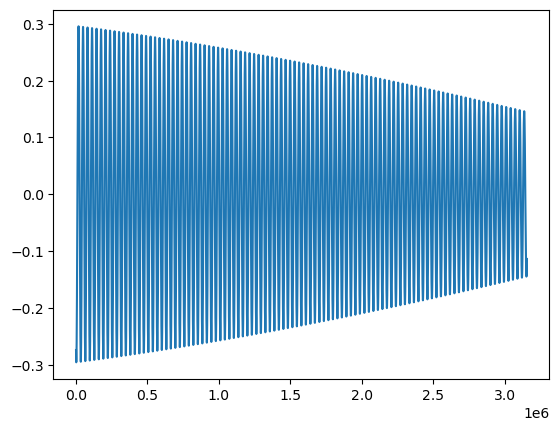

In [152]:
plt.plot(y[1] - p1[1])

In [5]:
from gwspace.Waveform import GCBWaveform as gcb
from gwspace.response import trans_y_slr_fd as trans
from gwspace.Orbit import get_pos
from gwspace.Waveform import BasicWaveform

In [6]:
def transfer_slr(freq, LT, knl, krr, krs):
    return 0.5 * np.sinc(freq*LT * (1-knl)) * np.exp(-1j*freq*(LT+krr+krs))

def _dot_arr(a,b):
    return a[0]*b[0]+a[1]*b[1]+a[2]*b[2]

def _cal_zeta(u,v,n):
    nu = _dot_arr(n,u)
    nv = _dot_arr(n,v)
    zp = nu**2 - nv**2
    zc = 2*nu*nv
    return zp, zc

def _cal_xi(tf,k,r):
    return tf - _dot_arr(k,r)

def get_yslr(tf, freq, u,v,k, wf, detector="TianQin"):
    xt,yt,zt,LT = get_pos(tf, detector)
    ni = lambda i,j: np.array([xt[j]-xt[i], yt[j]-yt[i], zt[j]-zt[i]])/LT    
    n1 = ni(2,1); n2 = ni(0,2); n3 = ni(1,0)
    kn1 = _dot_arr(k,n1)
    kn2 = _dot_arr(k,n2)
    kn3 = _dot_arr(k,n3)

    kr1 = _dot_arr(k, np.array([xt[0],yt[0],zt[0]]))
    kr2 = _dot_arr(k, np.array([xt[1],yt[1],zt[1]]))
    kr3 = _dot_arr(k, np.array([xt[2],yt[2],zt[2]]))

    zp1,zc1 = _cal_zeta(u,v,n1)
    zp2,zc2 = _cal_zeta(u,v,n2)
    zp3,zc3 = _cal_zeta(u,v,n3)

    sinc12 = np.sinc(freq*LT*(1+kn3))
    sinc23 = np.sinc(freq*LT*(1+kn1))
    sinc31 = np.sinc(freq*LT*(1+kn2))

    sinc21 = np.sinc(freq*LT*(1-kn3))
    sinc32 = np.sinc(freq*LT*(1-kn1))
    sinc13 = np.sinc(freq*LT*(1-kn2))

    exp12 = np.exp(-1j*np.pi*freq*(LT+kr1+kr2))
    exp23 = np.exp(-1j*np.pi*freq*(LT+kr2+kr3))
    exp31 = np.exp(-1j*np.pi*freq*(LT+kr3+kr1))

    yslr = {}
    for i in range(4):        
        ts = tf - i*LT
        hp, hc = wf.get_hphc(ts)
        cspsi = np.cos(2*wf.psi) 
        snpsi = np.sin(2*wf.psi)
        hp, hc = (hp*cspsi -hc*snpsi, hp*snpsi+hc*cspsi)

        fact = -1j*np.pi*freq*LT * np.exp(1j*2*np.pi*freq*LT*i)
        
        yslr["%sL"%i] = {
            (1,2): fact*sinc12*exp12*(zp3*hp + zc3*hc),
            (2,1): fact*sinc21*exp12*(zp3*hp + zc3*hc),
            (2,3): fact*sinc23*exp23*(zp1*hp + zc1*hc),
            (3,2): fact*sinc32*exp23*(zp1*hp + zc1*hc),
            (3,1): fact*sinc31*exp31*(zp2*hp + zc2*hc),
            (1,3): fact*sinc13*exp31*(zp2*hp + zc2*hc),
        }
    return yslr

class GCBWaveformFD(BasicWaveform):
    
    def __init__(self, mass1, mass2, T_obs, phi0, f0, fdot=None, fddot=None, DL=1., Lambda=None, Beta=None,
                 phi_c=0., tc=0., iota=0., var_phi=0., psi=0, **kwargs):
        BasicWaveform.__init__(self, mass1, mass2, T_obs, DL, Lambda, Beta,
                               phi_c, tc, iota, var_phi, psi, **kwargs)
        self.phi0 = phi0
        self.f0 = f0
        if fdot is None:
            self.fdot = (96/5*PI**(8/3) *
                         (G_SI*self.Mc*MSUN_SI/C_SI**3)**(5/3)
                         * f0**(11/3))
        else:
            self.fdot = fdot
        if fddot is None:
            self.fddot = 11/3*self.fdot**2/f0
        else:
            self.fddot = fddot
        self.amp = 2*(G_SI*self.Mc*MSUN_SI)**(5/3)
        self.amp = self.amp/C_SI**4/(DL*MPC_SI)
        self.amp = self.amp*(PI*f0)**(2/3)

    def get_h_exp(self, tf, freq=None):
        phase = 2*PI*(self.f0+0.5*self.fdot*t +
                      1/6*self.fddot*t*t)*t+self.phi0
        csi = cos(self.iota)
        if freq == None:
            freq = self.f0 + self.fdot*tf
        return self.amp*np.exp(1j*2*np.pi*freq*tf)

In [25]:
GCBpars = {
    "mass1": 0.5,
    "mass2": 0.275,
    "DL": 0.004716164547019551,
    "phi0": 3.1716561,
    "f0": 0.00622028,
    "fdot": 7.48528554e-16,
    "fddot": 0.0,
    "psi": 0.2,
    "iota": 0.645772,
    "Lambda": J0806_phi, #2.10225,
    "Beta": np.pi/2 - J0806_theta, #np.pi/2+0.082205,
    "T_obs": YRSID_SI,
}

gcbwf = gcb(**GCBpars)
#gcbwf = GCBWaveformFD(**GCBpars)

dt = 15
tf = np.arange(0,YRSID_SI, dt)
det = detectors["TQ"](tf)


In [31]:
J0806_phi, np.pi/2-J0806_theta

(2.103121748653167, -0.08203047484373349)

In [26]:
u,v,k = gcbwf.vec_u, gcbwf.vec_v, gcbwf.vec_k
hp, hc = gcbwf.get_hphc(tf)
freq = GCBpars["f0"]

yslr = get_yslr(tf, freq, u,v,k, gcbwf, detector="TianQin")

In [27]:
yslr.keys()

dict_keys(['0L', '1L', '2L', '3L'])

In [28]:
XX_td = ((yslr["0L"][(3,1)] + yslr["1L"][(1,3)] 
        + yslr["2L"][(2,1)] +yslr["3L"][(1,2)]) -
       (yslr["0L"][(2,1)] + yslr["1L"][(1,2)] 
        + yslr["2L"][(3,1)] +yslr["3L"][(1,3)]))

In [29]:
XX_fd = np.fft.rfft(XX_td.real)/(XX_td.shape[0])

ft = np.linspace(0,1/dt/2, XX_td.shape[0])

ft.shape, XX_fd.shape

((2103877,), (1051939,))

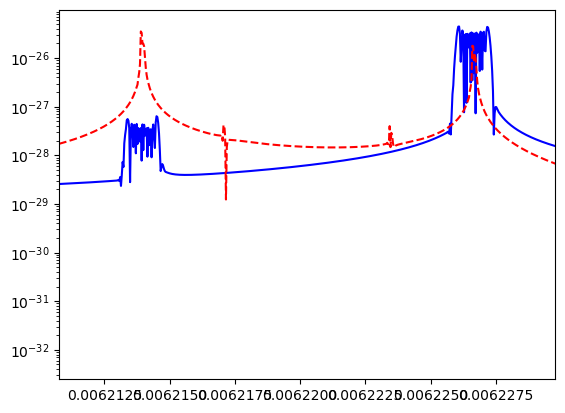

In [30]:
plt.plot(xf[1:], 2*np.abs(XX_fd[1:]), 'b')
plt.plot(xf, np.abs(X_fd), '--r')
#plt.xscale("log")
df = xf[1]-xf[0]
plt.xlim(f0-300*df, f0+300*df)

plt.yscale("log")

In [272]:
# %load test_Noise.py
#!/usr/bin/env python
# ==================================
# File Name: test_Noise.py
# Author: En-Kun Li, Han Wang
# Mail: lienk@mail.sysu.edu.cn, wanghan657@mail2.sysu.edu.cn
# Created Time: 2023-09-05 15:03:28
# ==================================

import numpy as np
import matplotlib.pyplot as plt

from gwspace.Noise import TianQinNoise, LISANoise
from gwspace.Constants import PI, C_SI
from gwspace.wrap import frequency_noise_from_psd


tq_noise = TianQinNoise()
lisa_noise = LISANoise()
taiji_noise = TaijiNoise()
freq_ = np.logspace(-5, 0, 10000)

TQ_A, _ = tq_noise.noise_AET(freq_)
LISA_A, _ = lisa_noise.noise_AET(freq_, wd_foreground=90/365.25)
Taiji_A, _ = taiji_noise.noise_AET(freq_)

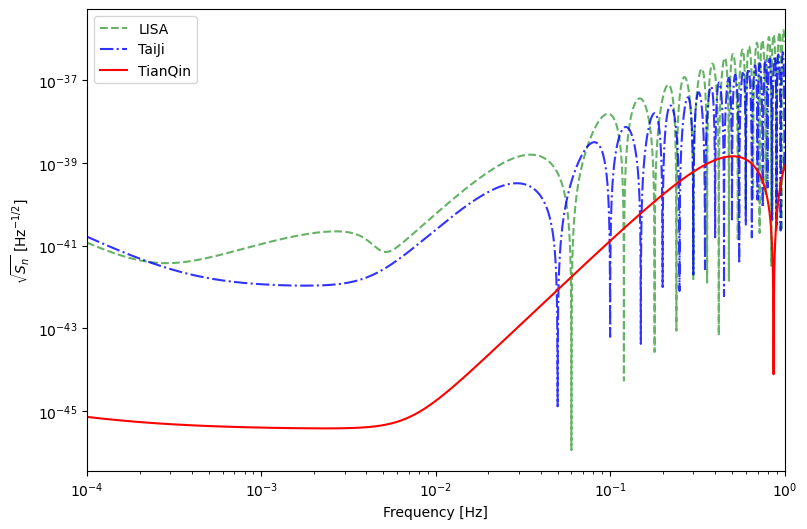

In [285]:
plt.figure(figsize=(9,6))

plt.plot(freq_, LISA_A, 'g--', alpha=0.6, label="LISA")
plt.plot(freq_, Taiji_A, 'b-.', alpha=0.8, label="TaiJi")
plt.plot(freq_, TQ_A, 'r-', label="TianQin")

plt.xscale("log")
plt.yscale("log")

plt.xlim(1e-4,1)

plt.xlabel("Frequency [Hz]")
plt.ylabel('$\\sqrt{S_n}$ [Hz$^{-1/2}$]')

plt.legend(loc="best")

plt.savefig("../../../TQ-SDS/figs/TDI_A_PSD.pdf")

In [270]:
1/YRSID_SI

3.168753578692357e-08